In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from folium.plugins import HeatMap
import geopandas as gpd

In [2]:
df = pd.read_csv('C:/Users/vishnu/Downloads/wildfiredb.csv')

In [3]:
print(df.columns)

Index(['Polygon_ID', 'acq_date', 'frp', 'Neighbour', 'Neighbour_frp',
       'CBC2014_max', 'CBC2014_min', 'CBC2014_median', 'CBC2014_sum',
       'CBC2014_mode',
       ...
       'Neighbour_NVC2016_mode', 'Neighbour_NVC2016_count',
       'Neighbour_NVC2016_mean', 'Neighbour_SLP2016_max',
       'Neighbour_SLP2016_min', 'Neighbour_SLP2016_median',
       'Neighbour_SLP2016_sum', 'Neighbour_SLP2016_mode',
       'Neighbour_SLP2016_count', 'Neighbour_SLP2016_mean'],
      dtype='object', length=397)


In [4]:
small_df = df.sample(frac=0.1, random_state=42)

fire_df = df[df['Neighbour_frp'] > 0]  # Rows with fire
no_fire_df = df[df['Neighbour_frp'] == 0]  # Rows without fire

# Then sample from each and combine
fire_sample = fire_df.sample(n=min(5000, len(fire_df)), random_state=42)
no_fire_sample = no_fire_df.sample(n=min(5000, len(no_fire_df)), random_state=42)
balanced_small_df = pd.concat([fire_sample, no_fire_sample])

# Don't forget to shuffle the combined dataset
balanced_small_df = balanced_small_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
def create_wildfire_heatmap(df):
    # Note: WildfireDB doesn't seem to have explicit Latitude/Longitude columns
    # We'll need to check if these coordinates are available in your dataset
    
    # If coordinates are not directly available, we can't create a geographic heatmap
    # Instead, let's create a 2D histogram of fire occurrences by Polygon_ID
    
    plt.figure(figsize=(12, 8))
    # Count fires by polygon
    polygon_counts = df.groupby('Polygon_ID')['frp'].count().reset_index()
    polygon_counts = polygon_counts.sort_values('frp', ascending=False).head(50)
    
    sns.barplot(x='Polygon_ID', y='frp', data=polygon_counts)
    plt.title('Top 50 Locations by Wildfire Frequency')
    plt.xlabel('Polygon ID')
    plt.ylabel('Number of Fire Occurrences')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('wildfire_frequency.png')
    plt.show()
    
    return polygon_counts

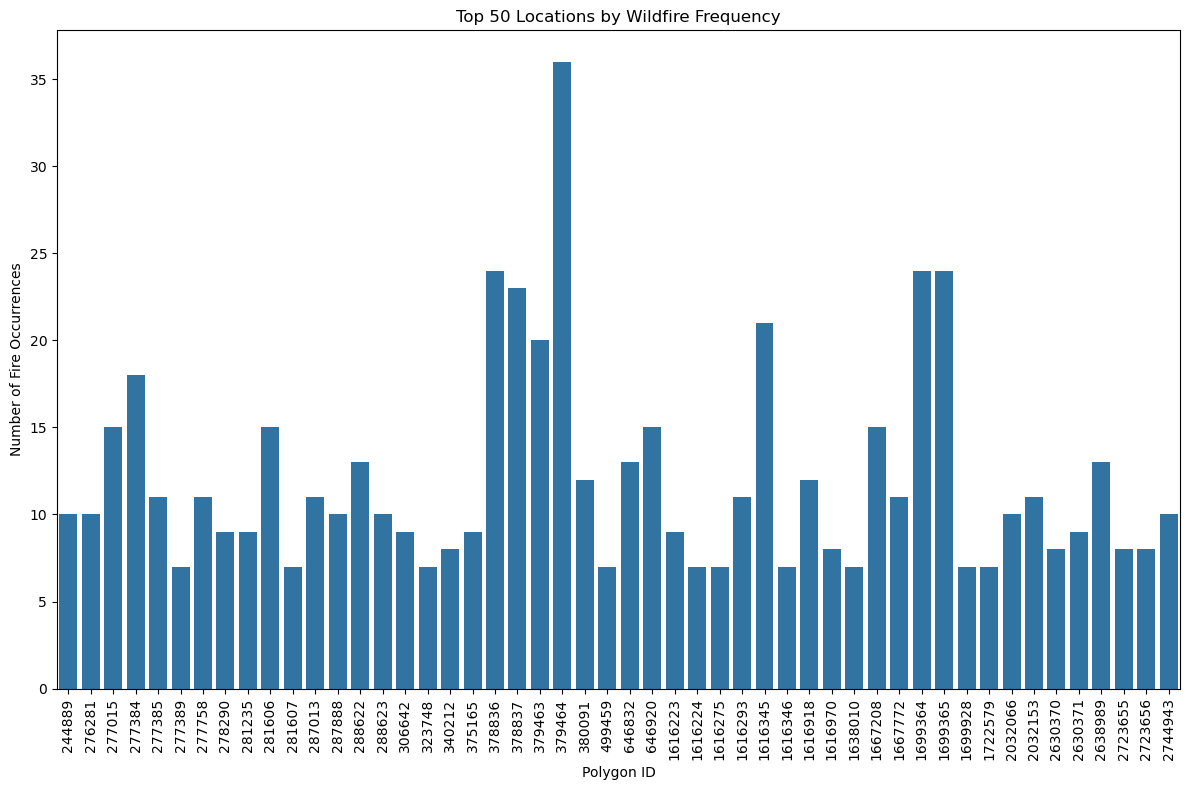

,Polygon_ID,frp
866,379464,36
861,378836,24
5081,1699365,24
5080,1699364,24
862,378837,23
5030,1616345,21
865,379463,20
673,277384,18
689,281606,15
1320,646920,15


In [9]:
create_wildfire_heatmap(balanced_small_df)

**Temporal Patterns of Wildfire Occurrences**

In [10]:
def plot_temporal_patterns(df):
    # Convert acquisition date to datetime
    df['acq_date'] = pd.to_datetime(df['acq_date'])
    
    # Extract year and month
    df['Year'] = df['acq_date'].dt.year
    df['Month'] = df['acq_date'].dt.month
    
    # Group by year and month, count occurrences
    monthly_counts = df.groupby(['Year', 'Month']).size().reset_index(name='Count')
    
    # Plot
    plt.figure(figsize=(12, 6))
    for year in monthly_counts['Year'].unique():
        year_data = monthly_counts[monthly_counts['Year'] == year]
        plt.plot(year_data['Month'], year_data['Count'], marker='o', label=str(year))
    
    plt.title('Monthly Wildfire Occurrences (2012-2018)')
    plt.xlabel('Month')
    plt.ylabel('Number of Wildfires')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(title='Year')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('temporal_patterns.png')
    plt.show()

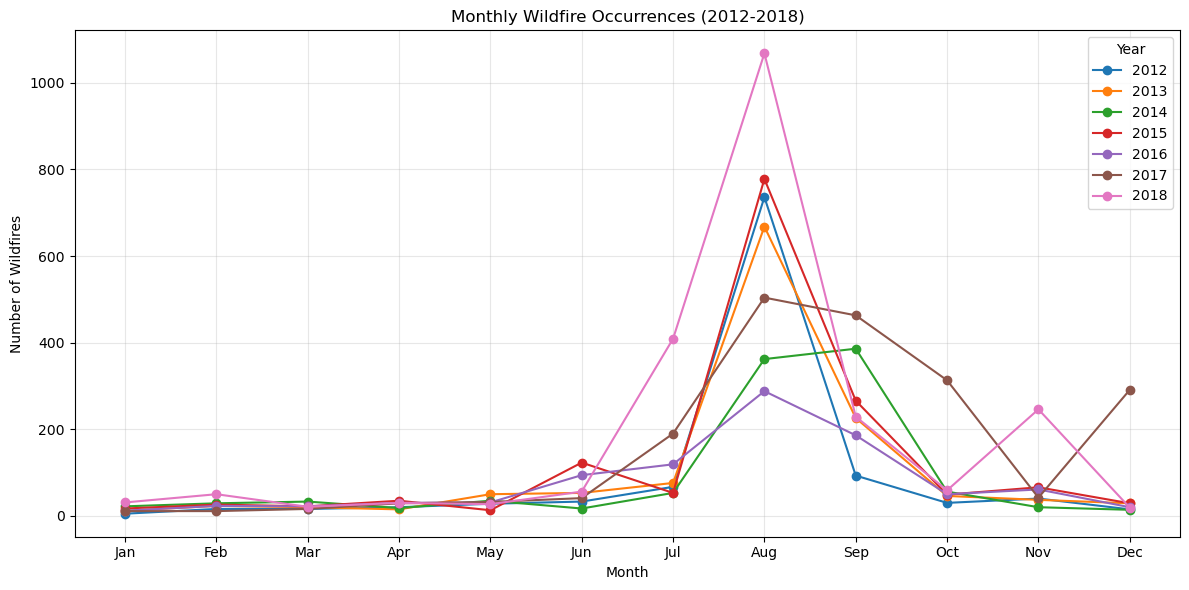

In [11]:
plot_temporal_patterns(balanced_small_df)

**Correlation Between Features**

In [12]:
def plot_correlation_matrix(df):
    # Select relevant columns - adjust based on your dataset
    features = ['frp', 'Neighbour_frp', 
                'CBC2014_mean', 'CBH2014_mean', 
                'EVC2016_mean', 'EVH2016_mean',
                'SLP2016_mean']
    
    # Calculate correlation matrix
    corr_matrix = df[features].corr()
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Between Wildfire Features')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    plt.show()

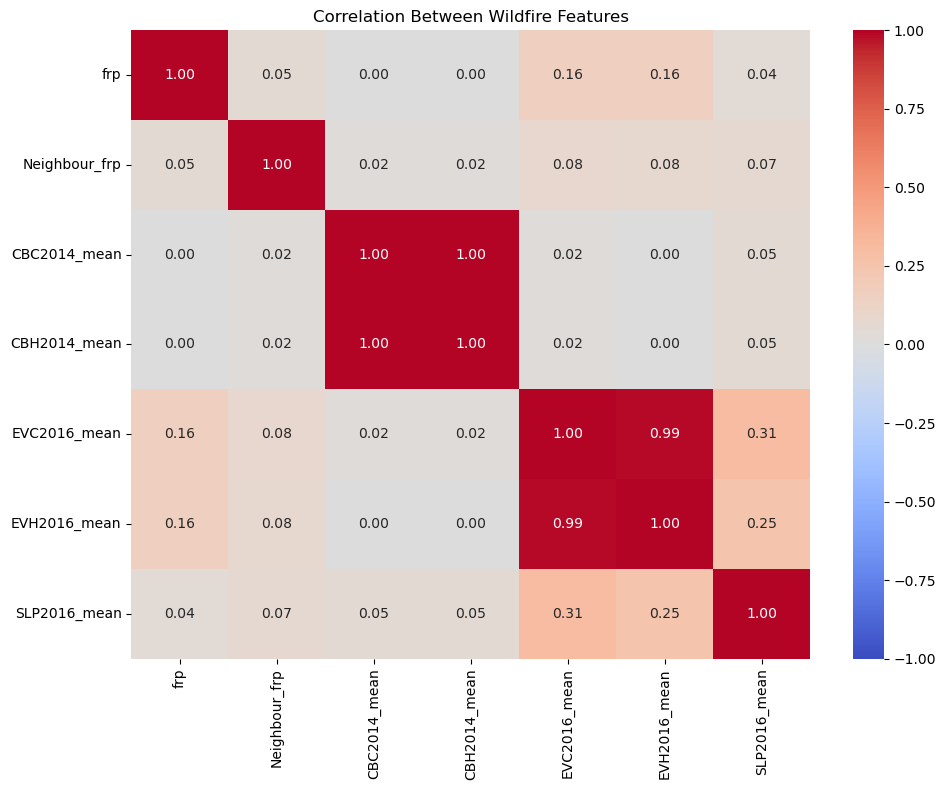

In [13]:
plot_correlation_matrix(balanced_small_df)

**Feature Importance Visualization**

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def plot_feature_importance(df):
    # Select features and target
    # Adjust these columns based on what's available in your dataset
    features = ['CBC2014_mean', 'CBH2014_mean', 
                'EVC2016_mean', 'EVH2016_mean',
                'SLP2016_mean', 'frp']
    
    X = df[features]
    y = df['Neighbour_frp']  # Target: fire spread to neighbor
    
    # Train a simple Random Forest model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Get feature importances
    importances = rf.feature_importances_
    indices = np.argsort(importances)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title('Random Forest Feature Importance for Fire Spread Prediction')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

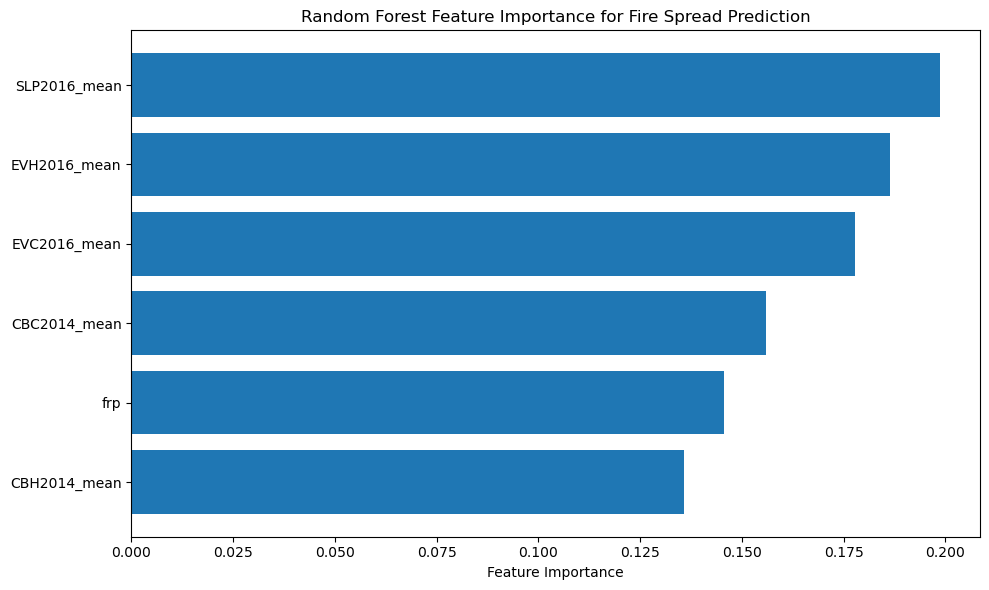

In [15]:
plot_feature_importance(balanced_small_df)

**Fire Intensity Distribution**

In [16]:
def plot_fire_intensity_distribution(df):
    plt.figure(figsize=(12, 6))
    
    # Current fire intensity distribution
    plt.subplot(1, 2, 1)
    sns.histplot(df['frp'], bins=30, kde=True)
    plt.title('Distribution of Fire Radiative Power (FRP)')
    plt.xlabel('Fire Radiative Power')
    plt.ylabel('Frequency')
    
    # Neighbor fire intensity distribution
    plt.subplot(1, 2, 2)
    sns.histplot(df[df['Neighbour_frp'] > 0]['Neighbour_frp'], bins=30, kde=True)
    plt.title('Distribution of Neighbor Fire Radiative Power')
    plt.xlabel('Neighbor Fire Radiative Power')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('fire_intensity_distribution.png')
    plt.show()

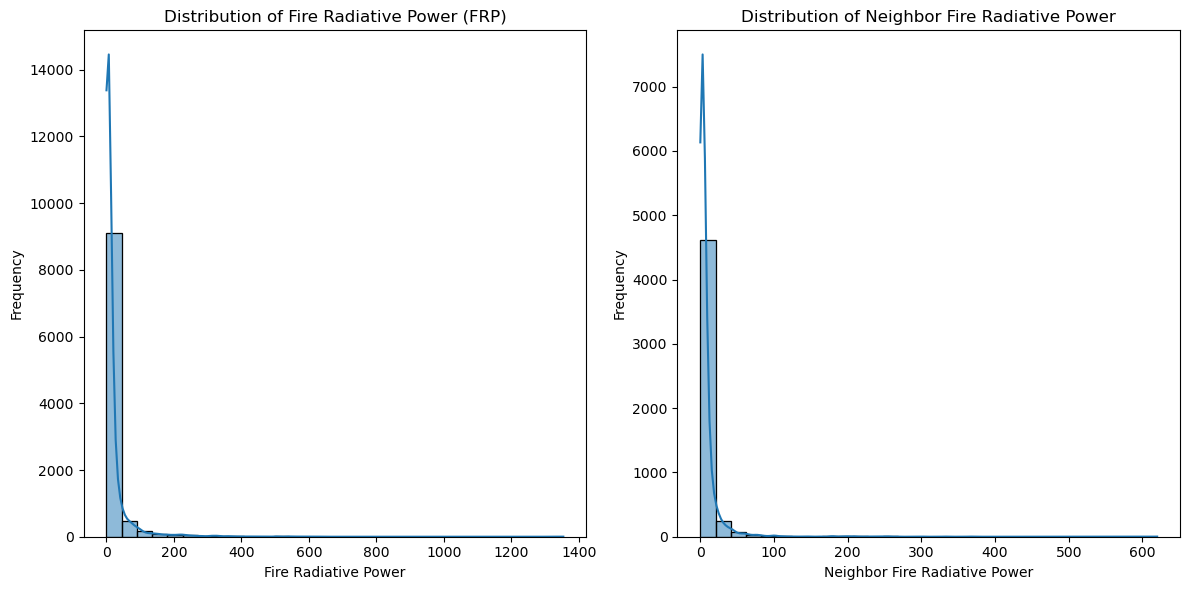

In [17]:
plot_fire_intensity_distribution(balanced_small_df)

**Fire Spread Visualization**

C:\Users\vishnu\AppData\Local\Temp\ipykernel_25032\811942407.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spread_data = df.groupby('frp_bin')['Neighbour_frp'].mean().reset_index()


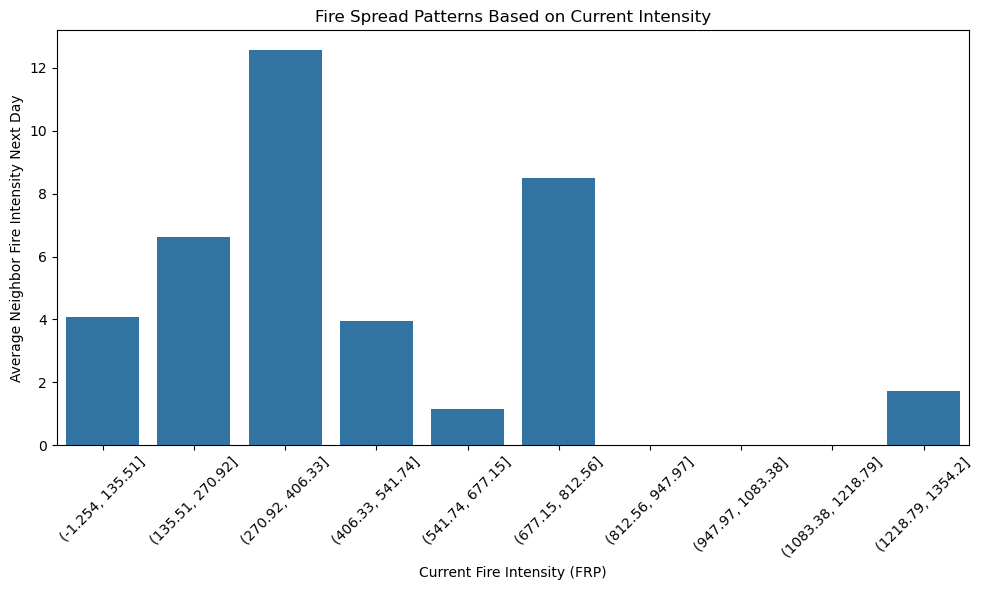

In [18]:
def plot_fire_spread_patterns(df):
    # Group by initial FRP and calculate average neighbor FRP
    df['frp_bin'] = pd.cut(df['frp'], bins=10)
    spread_data = df.groupby('frp_bin')['Neighbour_frp'].mean().reset_index()
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=spread_data['frp_bin'].astype(str), y=spread_data['Neighbour_frp'])
    plt.xticks(rotation=45)
    plt.xlabel('Current Fire Intensity (FRP)')
    plt.ylabel('Average Neighbor Fire Intensity Next Day')
    plt.title('Fire Spread Patterns Based on Current Intensity')
    plt.tight_layout()
    plt.savefig('fire_spread.png')
    plt.show()

plot_fire_spread_patterns(balanced_small_df)


**Topographical Impact on Fire Behavior**

In [22]:
elv_cols = [col for col in df.columns if 'ELV' in col]
print("Elevation columns:", elv_cols)

slp_cols = [col for col in df.columns if 'SLP' in col]
print("Slope columns:", slp_cols)

veg_cols = [col for col in df.columns if 'EVC' in col]
print("Vegetation cover columns:", veg_cols)

height_cols = [col for col in df.columns if 'EVH' in col]
print("Vegetation height columns:", height_cols)

Elevation columns: []
Slope columns: ['SLP2016_max', 'SLP2016_min', 'SLP2016_median', 'SLP2016_sum', 'SLP2016_mode', 'SLP2016_count', 'SLP2016_mean', 'Neighbour_SLP2016_max', 'Neighbour_SLP2016_min', 'Neighbour_SLP2016_median', 'Neighbour_SLP2016_sum', 'Neighbour_SLP2016_mode', 'Neighbour_SLP2016_count', 'Neighbour_SLP2016_mean']
Vegetation cover columns: ['EVC2012_max', 'EVC2012_min', 'EVC2012_median', 'EVC2012_sum', 'EVC2012_mode', 'EVC2012_count', 'EVC2012_mean', 'EVC2014_max', 'EVC2014_min', 'EVC2014_median', 'EVC2014_sum', 'EVC2014_mode', 'EVC2014_count', 'EVC2014_mean', 'EVC2016_max', 'EVC2016_min', 'EVC2016_median', 'EVC2016_sum', 'EVC2016_mode', 'EVC2016_count', 'EVC2016_mean', 'Neighbour_EVC2012_max', 'Neighbour_EVC2012_min', 'Neighbour_EVC2012_median', 'Neighbour_EVC2012_sum', 'Neighbour_EVC2012_mode', 'Neighbour_EVC2012_count', 'Neighbour_EVC2012_mean', 'Neighbour_EVC2014_max', 'Neighbour_EVC2014_min', 'Neighbour_EVC2014_median', 'Neighbour_EVC2014_sum', 'Neighbour_EVC2014_m

In [25]:
def plot_topographical_impact(df):
    plt.figure(figsize=(12, 10))
    
    # Find appropriate columns for elevation, slope, etc.
    elv_cols = [col for col in df.columns if 'ELV' in col]
    slp_cols = [col for col in df.columns if 'SLP' in col]
    veg_cover_cols = [col for col in df.columns if 'EVC' in col]
    veg_height_cols = [col for col in df.columns if 'EVH' in col]
    
    # Select one column from each category if available
    elevation_col = elv_cols[0] if elv_cols else None
    slope_col = slp_cols[0] if slp_cols else None
    veg_cover_col = veg_cover_cols[0] if veg_cover_cols else None
    veg_height_col = veg_height_cols[0] if veg_height_cols else None
    
    # Only create plots for available columns
    plot_count = 0
    
    if elevation_col:
        plot_count += 1
        plt.subplot(2, 2, plot_count)
        sns.scatterplot(data=df, x=elevation_col, y='frp', alpha=0.5)
        plt.xlabel('Elevation')
        plt.ylabel('Fire Radiative Power (FRP)')
        plt.title(f'{elevation_col} vs Fire Intensity')
    
    if slope_col:
        plot_count += 1
        plt.subplot(2, 2, plot_count)
        sns.scatterplot(data=df, x=slope_col, y='frp', alpha=0.5)
        plt.xlabel('Slope')
        plt.ylabel('Fire Radiative Power (FRP)')
        plt.title(f'{slope_col} vs Fire Intensity')
    
    if veg_cover_col:
        plot_count += 1
        plt.subplot(2, 2, plot_count)
        sns.scatterplot(data=df, x=veg_cover_col, y='frp', alpha=0.5)
        plt.xlabel('Vegetation Cover')
        plt.ylabel('Fire Radiative Power (FRP)')
        plt.title(f'{veg_cover_col} vs Fire Intensity')
    
    if veg_height_col:
        plot_count += 1
        plt.subplot(2, 2, plot_count)
        sns.scatterplot(data=df, x=veg_height_col, y='frp', alpha=0.5)
        plt.xlabel('Vegetation Height')
        plt.ylabel('Fire Radiative Power (FRP)')
        plt.title(f'{veg_height_col} vs Fire Intensity')
    
    plt.tight_layout()
    plt.savefig('topographical_impact.png')
    plt.show()


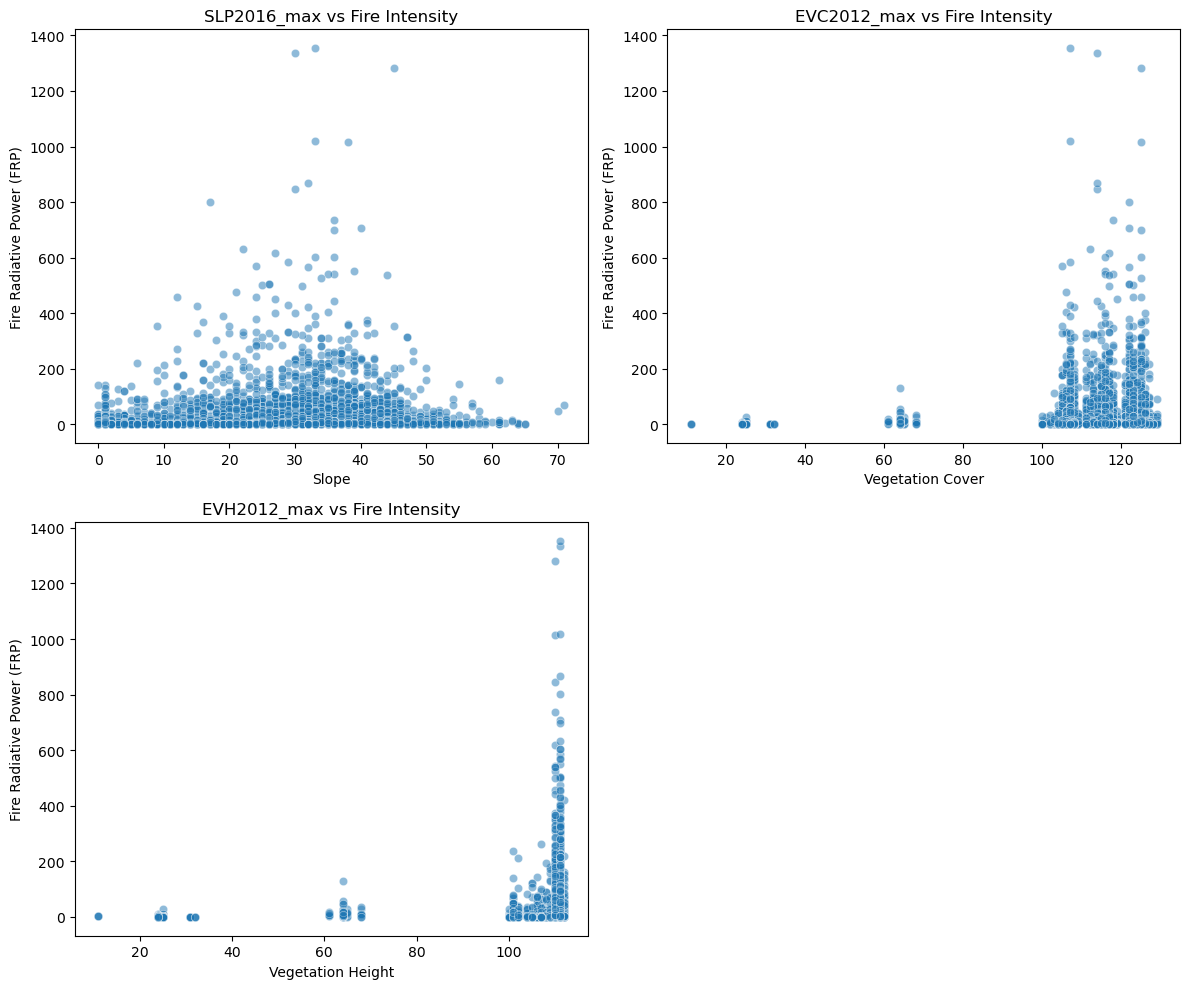

In [26]:
plot_topographical_impact(balanced_small_df)

**Check Point 2**

In [82]:
!pip install torch
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import torch

  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 1.0/204.1 MB 5.6 MB/s eta 0:00:37
    --------------------------------------- 2.6/204.1 MB 7.2 MB/s eta 0:00:29
    --------------------------------------- 4.2/204.1 MB 7.4 MB/s eta 0:00:27
   - -------------------------------------- 5.8/204.1 MB 7.5 MB/s eta 0:00:27
   - -------------------------------------- 7.3/204.1 MB 7.5 MB/s eta 0:00:27
   - -------------------------------------- 8.4/204.1 MB 7.3 MB/s eta 0:00:27
   - -------------------------------------- 9.4/204.1 MB 6.7 MB/s eta 0:00:29
   -- ------------------------------------- 10.7/204.1 MB 6.6 MB/s eta 0:00:30
   -- ------------------------------------- 12.6/204.1 MB 6.9 MB/s eta 0:00:28
   -- ------------------------------------- 13.4/204.1 MB 6.7 MB/s eta 0:00:29
   -- ------------------------------------- 14.7/204.1 MB 6.6 MB/s eta 0:00:29
   --

In [93]:
df = pd.read_csv("C:/Users/vishnu/Desktop/MSDS Sem 2/Data Mining/Project/reduced_dataset.csv")
print(f"Initial data shape: {df.shape}")

Initial data shape: (473441, 397)


In [70]:
df.columns.tolist()

['Polygon_ID',
 'acq_date',
 'frp',
 'Neighbour',
 'Neighbour_frp',
 'CBC2014_max',
 'CBC2014_min',
 'CBC2014_median',
 'CBC2014_sum',
 'CBC2014_mode',
 'CBC2014_count',
 'CBC2014_mean',
 'CBD2012_max',
 'CBD2012_min',
 'CBD2012_median',
 'CBD2012_sum',
 'CBD2012_mode',
 'CBD2012_count',
 'CBD2012_mean',
 'CBD2016_max',
 'CBD2016_min',
 'CBD2016_median',
 'CBD2016_sum',
 'CBD2016_mode',
 'CBD2016_count',
 'CBD2016_mean',
 'CBH2012_max',
 'CBH2012_min',
 'CBH2012_median',
 'CBH2012_sum',
 'CBH2012_mode',
 'CBH2012_count',
 'CBH2012_mean',
 'CBH2014_max',
 'CBH2014_min',
 'CBH2014_median',
 'CBH2014_sum',
 'CBH2014_mode',
 'CBH2014_count',
 'CBH2014_mean',
 'CBH2016_max',
 'CBH2016_min',
 'CBH2016_median',
 'CBH2016_sum',
 'CBH2016_mode',
 'CBH2016_count',
 'CBH2016_mean',
 'CC2012_max',
 'CC2012_min',
 'CC2012_median',
 'CC2012_sum',
 'CC2012_mode',
 'CC2012_count',
 'CC2012_mean',
 'CC2014_max',
 'CC2014_min',
 'CC2014_median',
 'CC2014_sum',
 'CC2014_mode',
 'CC2014_count',
 'CC2014_m

In [95]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
import matplotlib.pyplot as plt
from tensorflow.keras import layers


# Select key features
temporal_features = [
    'frp',                  # Fire radiative power
    'CBD2016_mean',         # Canopy bulk density
    'ELEV2016_mean'         # Elevation
]

spatial_features = [
    'Neighbour_frp',
    'Neighbour_ELEV2016_mean',
    'Neighbour_SLP2016_mean'  # Slope
]

# Add date features
df['acq_date'] = pd.to_datetime(df['acq_date'])
df['day_of_year'] = df['acq_date'].dt.dayofyear
df['month'] = df['acq_date'].dt.month

# Handle missing values
df[temporal_features + spatial_features] = df[temporal_features + spatial_features].fillna(
    df[temporal_features + spatial_features].median()
)

# Normalize features
scaler = StandardScaler()
df[temporal_features + spatial_features] = scaler.fit_transform(
    df[temporal_features + spatial_features]
)

In [ ]:

# ======================
# 2. Sequence Creation
# ======================

def create_sequences(data, seq_length=7):
    X_temp, X_spatial, y = [], [], []
    
    for polygon_id in data['Polygon_ID'].unique():
        poly_data = data[data['Polygon_ID'] == polygon_id].sort_values('acq_date')
        
        for i in range(len(poly_data) - seq_length):
            # Temporal features (7-day window)
            X_temp.append(poly_data.iloc[i:i+seq_length][temporal_features].values)
            
            # Spatial features (current day)
            X_spatial.append(poly_data.iloc[i+seq_length][spatial_features].values)
            
            # Target (fire if FRP > 1 std dev above mean)
            y.append(1 if poly_data.iloc[i+seq_length]['frp'] > 1.0 else 0)
    
    return np.array(X_temp), np.array(X_spatial), np.array(y)

X_temp, X_spatial, y = create_sequences(df)

# Combine temporal and spatial features
X = np.concatenate([
    X_temp.reshape(X_temp.shape[0], -1),  # Flatten temporal sequences
    X_spatial
], axis=1)

y = y.reshape(-1, 1)  # Ensure proper shape

In [ ]:
# ======================
# 3. Train-Test Split
# ======================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ======================
# 4. Custom Loss Class
# ======================

class BalancedLoss(tf.keras.losses.Loss):
    def __init__(self, pos_weight=10.0):
        super().__init__()
        self.pos_weight = pos_weight
        
    def call(self, y_true, y_pred):
        y_true = tf.reshape(y_true, tf.shape(y_pred))
        loss = tf.nn.weighted_cross_entropy_with_logits(
            y_true, y_pred, pos_weight=self.pos_weight)
        return tf.reduce_mean(loss)

# ======================
# 5. Model Architecture
# ======================

def build_balanced_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Temporal processing
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(inputs)
    x = layers.Dropout(0.3)(x)
    
    # Attention mechanism
    attention = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Concatenate()([x, attention])
    x = layers.LayerNormalization()(x)
    
    # Feature extraction
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# ======================
# 6. Model Training
# ======================

model = build_balanced_model((7 * len(temporal_features) + len(spatial_features),))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=BalancedLoss(pos_weight=15.0),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc', curve='PR')
    ]
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_recall', mode='max'),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_recall', mode='max')
    ]
)

In [ ]:
# ======================
# 7. Evaluation
# ======================

y_probs = model.predict(X_test)
y_pred = (y_probs > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred, target_names=['No Fire', 'Fire']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [ ]:
# ======================
# 8. Save Model
# ======================

model.save("wildfire_risk_model.h5")
print("Model saved successfully")